In [38]:
import torch
import inspect
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules.activation as A
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
class GeneratorNet(nn.Module):
    def __init__(self, cz=100, gf_dim=64):
        super(GeneratorNet, self).__init__()
        start_channel = 16*gf_dim
        assert start_channel % 2==0
        channels = [start_channel] # Stores channels for layers 1->4
        for i in range(1,4):
            channels.append(channels[i-1]//2)
        self.model = nn.Sequential(
            # Project and reshape
            nn.ConvTranspose2d(cz, channels[0], 4, 1, 0, bias=False),
            A.ReLU(),
            nn.BatchNorm2d(channels[0]),
            # Conv1. (?, channels[0], 4, 4) -> (?, channels[1], 8, 8)
            nn.ConvTranspose2d(channels[0], channels[1], 4, 2, 1, bias=True),
            A.ReLU(),
            nn.BatchNorm2d(channels[1]),
            # Conv2. (?, channels[1], 8, 8) -> (?, channels[2], 16, 16)
            nn.ConvTranspose2d(channels[1], channels[2], 4, 2, 1, bias=True),
            A.ReLU(),
            nn.BatchNorm2d(channels[2]),
            # Conv3. (?, channels[2], 16, 16) -> (?, channels[3], 32, 32)
            nn.ConvTranspose2d(channels[2], channels[3], 4, 2, 1, bias=True),
            A.ReLU(),
            nn.BatchNorm2d(channels[3]),
            # Conv4. (?, channels[3], 32, 32) -> (?, 3, 64, 64)
            nn.ConvTranspose2d(channels[3], 3, 2, 1, bias=True),
            A.Tanh()
        )
        
    def forward(self, z):
        """
        Input: 
            - z: minibatch of 1D noise vectors/"codes"
        Shapes:
            - z: (N, C) where N is batch_size and C is channels of z.
        """
        return self.model(z)

In [ ]:
Z = torch.sort(torch.Tensor(16384, 100, 1, 1).uniform_(-1, 1), dim=0)[0]
Y = torch.sort(torch.Tensor(16384, 1).normal_(), dim=0)[0]
# Y = torch.sort(torch.Tensor(16384, 1).uniform_(2, 3), dim=0)[0]
dataset = torch.utils.data.TensorDataset(Z, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
criterion = torch.nn.MSELoss()
gnet=GeneratorNet(cz=100, gf_dim=64)
test_z = list(dataloader)[0][0]
gnet(test_z)

In [ ]:
gnet = GeneratorNet()
optimizer = optim.Adam(gnet.parameters())

batch_mod = 300
epoch_mod = 2
for epoch in range(5):
    running_loss = 0.0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data
        outputs = gnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # Why...
        running_loss += loss.item()
        if (batch_idx % batch_mod == 0 and batch_idx > 0 and epoch % epoch_mod == 0):
            print(F"Epoch: {epoch}, Batch: {batch_idx}, Loss: {running_loss/batch_mod}")
            running_loss = 0.0

/Users/richard/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


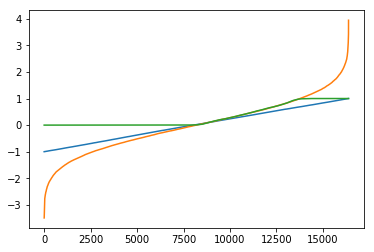

In [7]:
plot(X.numpy())
plot(Y.numpy())
plot(gnet(X).data.numpy())

In [18]:
class GeneratorLoss(torch.nn.Module):
    """Creates a criterion that measures the average log complements, across noise samples 'z', 
    of the discriminator D(.) applied to the generated sample G(z_i).

    Args: 
        - generator: Generator network.
        - discriminator: Discriminator network.

    Shape:
        - z: (N, *)  where N is minibatch size and `*` means any number of additional dimensions
    """
    def __init__(self, generator, discriminator):
        super(GeneratorLoss, self).__init__()
        self.G = generator
        self.D = discriminator

    def forward(self, z):
#         import ipdb; ipdb.set_trace()
        return torch.mean(torch.log(1-self.D(self.G(z)) + (2**-23)))

In [25]:
class DiscriminatorLoss(torch.nn.Module):
    def __init__(self, discriminator, generator_loss):
        super(DiscriminatorLoss, self).__init__()
        self.D = discriminator
        self.GL = generator_loss
    
    def forward(self, x, z):
        assert x.shape[0] == z.shape[0]
        return torch.mean(torch.log(self.D(x)))+self.GL(z)

In [26]:
gl = GeneratorLoss(gnet, gnet)
dl = DiscriminatorLoss(gnet, gl)

In [27]:
dl(torch.unsqueeze(torch.ones(10), dim=1), torch.unsqueeze(torch.ones(10), dim=1))

/Users/richard/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(-15.9424, grad_fn=<ThAddBackward>)